### **Fraud Detection Predictive Model**
Goal: Build 2 separate classifiers to be stacked alongside each other subsequently for a stronger predictive model. 

TabNet will be used as one of the models, which supports class weighting through loss_fn parameter. Thus, the second model should also support class weighting directly for stacking to work effectively.

To complement TabNet strengths, gradient boosting methods emerge as the top candidate.

Note: Due to RAM usage from feature engineering, load prepared data directly into the modelling section before executing code.

First, load necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load cleaned data
df = pd.read_csv('cleaned_data.csv')

# Load mcc data
json_file_path = "/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/Fraud data/mcc_codes.json"
with open(json_file_path, "r") as file:
    mcc = json.load(file)

# Convert to df
mcc = pd.DataFrame.from_dict(mcc, orient='index').reset_index()
mcc['index'] = mcc['index'].astype(int)

# Merge df and mcc into single df
df = df.merge(mcc, left_on='mcc', right_on='index', how='left')
df = df.rename(columns={0: 'merchant information'})
df.drop(columns=['index'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 40 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   date                         object 
 2   client_id                    int64  
 3   card_id                      int64  
 4   amount                       float64
 5   merchant_id                  int64  
 6   merchant_city                object 
 7   zip                          int64  
 8   mcc                          int64  
 9   Target                       int64  
 10  current_age                  int64  
 11  retirement_age               int64  
 12  birth_year                   int64  
 13  birth_month                  int64  
 14  address                      object 
 15  latitude                     float64
 16  longitude                    float64
 17  per_capita_income            float64
 18  yearly_income                float64
 19  

In [3]:
# Descriptive stats for each column
pd.set_option('display.max_columns', None)
df.describe()

,id,client_id,card_id,amount,merchant_id,zip,mcc,Target,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,transaction_hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_state_CA,merchant_state_FL,merchant_state_IL,merchant_state_MI,merchant_state_NC,merchant_state_NY,merchant_state_OH,merchant_state_ONLINE,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male
count,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06
mean,1.558473e+07,1.026637e+03,3.474887e+03,3.165506e+00,4.772566e+04,5.696165e+04,5.565097e+03,1.495463e-03,5.402147e+01,6.648777e+01,1.965160e+03,6.567033e+00,3.737615e+01,-9.156999e+01,9.956725e+00,1.062341e+01,9.918007e+00,7.139262e+02,3.841198e+00,1.238931e+01,3.592585e-01,1.171037e-01,5.236378e-01,1.072754e-01,5.267549e-02,3.517592e-02,2.992104e-02,3.218600e-02,6.444457e-02,3.635439e-02,1.175400e-01,4.170598e-01,3.141202e-02,7.595533e-02,5.123041e-01,4.876959e-01
std,4.703991e+06,5.816755e+02,1.674427e+03,1.311322e+00,2.581623e+04,3.153351e+04,8.755078e+02,3.864230e-02,1.572477e+01,3.587085e+00,1.571386e+01,3.605192e+00,5.091677e+00,1.626130e+01,7.833352e-01,6.439853e-01,2.593639e+00,6.581489e+01,1.567701e+00,5.087697e+00,4.797831e-01,3.215438e-01,4.994410e-01,3.094631e-01,2.233848e-01,1.842243e-01,1.703695e-01,1.764938e-01,2.455432e-01,1.871704e-01,3.220627e-01,4.930730e-01,1.744285e-01,2.649266e-01,4.998486e-01,4.998486e-01
min,7.475327e+06,0.000000e+00,0.000000e+00,6.931472e-01,1.000000e+00,1.001000e+03,1.711000e+03,0.000000e+00,2.300000e+01,5.300000e+01,1.918000e+03,1.000000e+00,2.130000e+01,-1.581800e+02,6.931472e-01,6.931472e-01,6.931472e-01,4.880000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.150786e+07,5.190000e+02,2.413000e+03,2.295560e+00,2.588700e+04,3.010100e+04,5.300000e+03,0.000000e+00,4.200000e+01,6.500000e+01,1.956000e+03,3.000000e+00,3.389000e+01,-9.737000e+01,9.747652e+00,1.039873e+01,9.707351e+00,6.840000e+02,3.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.557140e+07,1.070000e+03,3.584000e+03,3.400864e+00,4.592600e+04,5.511600e+04,5.499000e+03,0.000000e+00,5.200000e+01,6.600000e+01,1.968000e+03,7.000000e+00,3.835000e+01,-8.647000e+01,9.959726e+00,1.062357e+01,1.085283e+01,7.160000e+02,4.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.965387e+07,1.530000e+03,4.899000e+03,4.169452e+00,6.757000e+04,9.066000e+04,5.812000e+03,0.000000e+00,6.300000e+01,6.800000e+01,1.977000e+03,1.000000e+01,4.112000e+01,-8.012000e+01,1.021497e+01,1.089700e+01,1.135230e+01,7.560000e+02,5.000000e+00,1.600000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.376187e+07,1.998000e+03,6.138000e+03,5.758460e+00,1.003420e+05,9.992800e+04,9.402000e+03,1.000000e+00,1.010000e+02,7.900000e+01,1.996000e+03,1.200000e+01,4

### EDA Extension

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_58136/1003716708.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  frauds_time = df.groupby(pd.Grouper(key='date', freq='Y'))['Target'].sum()


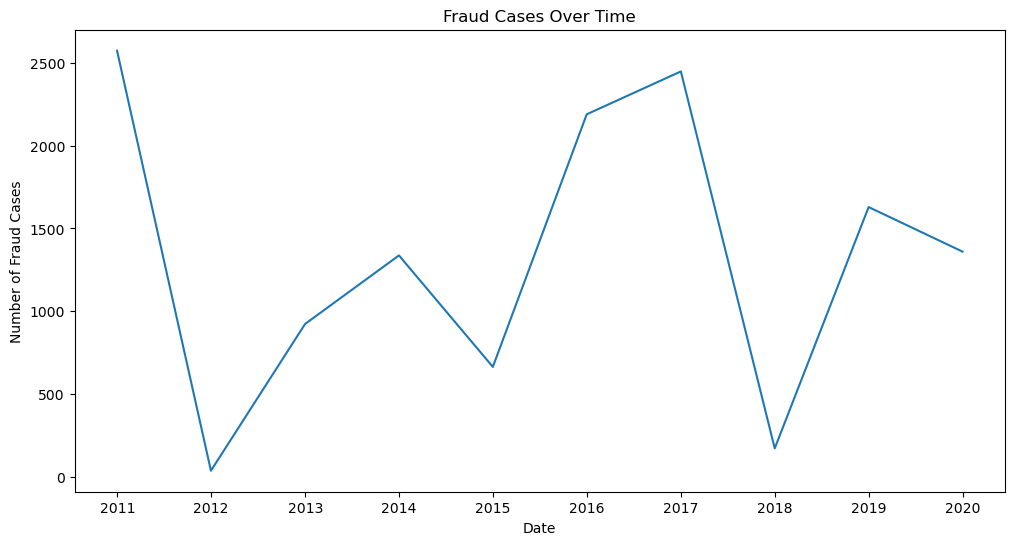

In [4]:
# Extract day of week data for each observation for subsequent individual purchase behaviour assessment
df['date'] = pd.to_datetime(df['date'])
df['transaction_day'] = df['date'].dt.dayofweek

# Group by date and count fraud
frauds_time = df.groupby(pd.Grouper(key='date', freq='Y'))['Target'].sum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=frauds_time.index, y=frauds_time.values)
plt.title('Fraud Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Fraud Cases')
plt.show()

# No value in keeping date as it is

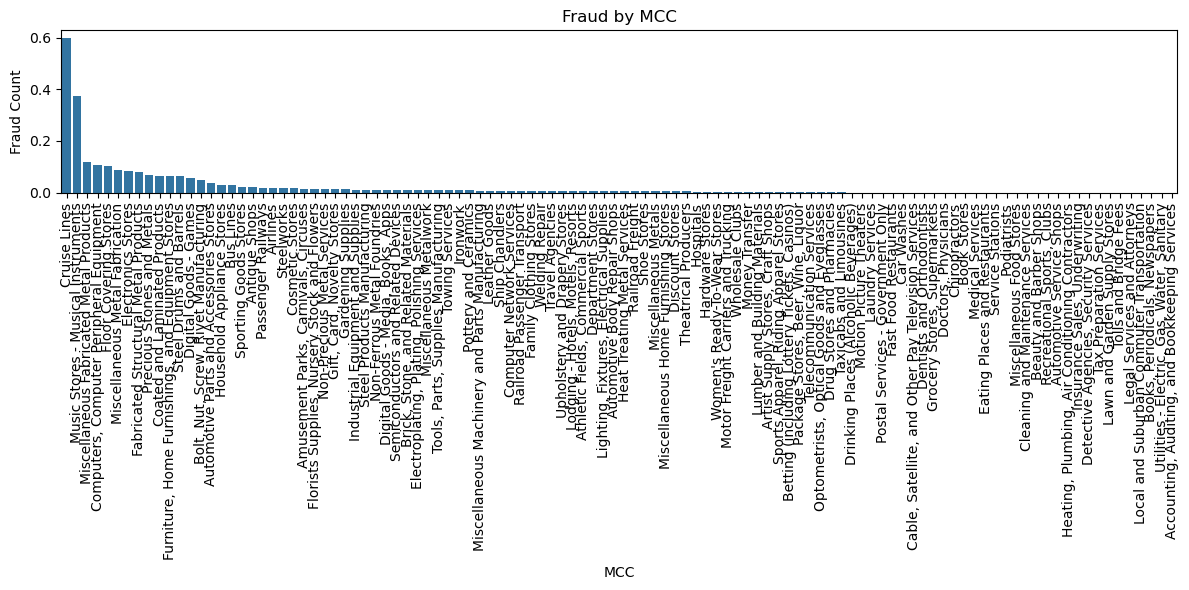

In [5]:
# Group by mcc and calculate overall fraud rate
fraud_mcc = df.groupby('merchant information')['Target'].mean().sort_values(ascending=False)

# Visualise fraud rate for each merchant
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_mcc.index, y=fraud_mcc.values)
plt.title('Fraud by MCC')
plt.xlabel('MCC')
plt.ylabel('Fraud Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
# Drop irrelevant columns
df = df.drop(df.columns[[0,3,5,8,12,13]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 35 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   client_id                    int64         
 2   amount                       float64       
 3   merchant_city                object        
 4   zip                          int64         
 5   Target                       int64         
 6   current_age                  int64         
 7   retirement_age               int64         
 8   address                      object        
 9   latitude                     float64       
 10  longitude                    float64       
 11  per_capita_income            float64       
 12  yearly_income                float64       
 13  total_debt                   float64       
 14  credit_score                 int64         
 15  num_credit_cards             int64         
 16  

#### **Feature engineering**

#### Engineer merchant risk score from merchant characteristics

In [7]:
# Binary col for high risk mcc - disregarded this in favour of a risk score below

# Filter out high risk mcc according to fraud rate with top 10% as cut off, and transaction amount with whisker as cut off, and the freq of fraud 
def high_risk_mcc_by_transact_type(df):
    """
    Filters out MCCs with a high risk of fraud considering transaction types using upper whisker value as the benchmark cut off
    Rationale: Amount quartiles are different across transaction types (refer to EDA) and thus, the high risk mcc can be significantly different from 1 to the other
    Returns: List of MCCs to filter out.
    """
    transaction_types =['Chip Transaction', 'Online Transaction', 'Swipe Transaction']
    high_risk_mccs = []

    for t in transaction_types:
        # Split into respective transaction type
        df_type = df[df['use_chip_' + t] == 1]
        # Calculate fraud rate for each mcc
        fraud_mcc = df_type.groupby('merchant information')['Target'].mean().sort_values(ascending=False)
        # Filter out high risk mccs in the top 10%
        high_risk_mccs_fraud = fraud_mcc.head(int(len(fraud_mcc) * 0.1)).index.to_list()

        # Calculate quartiles for amounts per merch
        mcc_quartiles = df_type.groupby('merchant information')['amount'].quantile([0.25, 0.75]).unstack()
        mcc_quartiles.columns = ['Q1', 'Q3']
        mcc_quartiles['IQR'] = mcc_quartiles['Q3'] - mcc_quartiles['Q1']
        mcc_quartiles['amount_threshold'] = mcc_quartiles['Q3'] + 1.5 * mcc_quartiles['IQR'] # upper whisker value

        # Count occurence of high transaction amounts per merchant
        df_merged = pd.merge(df_type, mcc_quartiles, on='merchant information', how='left')
        df_merged['high_amount'] = (df_merged['amount'] >= df_merged['amount_threshold']).astype(int)
        high_amount_counts = df_merged.groupby('merchant information')['high_amount'].sum().reset_index()
        high_amount_counts.rename(columns={'high_amount': 'high_amount_count'}, inplace=True)

        # Calculate the ratio of high transaction amount relative to total transactions
        total_transaction_counts = df_type.groupby('merchant information').size().reset_index(name='total_transactions') # number of transactions per merchant
        mcc_ratios = pd.merge(high_amount_counts, total_transaction_counts, on='merchant information')
        mcc_ratios['high_amount_ratio'] = mcc_ratios['high_amount_count'] / mcc_ratios['total_transactions']

        # Filter merchant on threshold of 75%
        high_risk_mccs_amt = mcc_ratios[mcc_ratios['high_amount_ratio'] > 0.77]['merchant information'].tolist()

        # Combine high risk mcc for each transaction type 
        high_risk_mccs_type = list(set(high_risk_mccs_amt + high_risk_mccs_fraud))
        high_risk_mccs.extend(high_risk_mccs_type)
    
    # Combine mccs across all transaction types
    high_risk_mccs = list(set(high_risk_mccs))
    return high_risk_mccs

#high_risk_mccs = high_risk_mcc_by_transact_type(df)

#print(f'High risk merchants include: {high_risk_mccs}')

# Create new column for high risk merchant
#df['high_risk_merchant'] = df['merchant information'].isin(high_risk_mccs).astype(int)

In [8]:
# Assign risk score to each merchant based on fraud rate and transaction amount instead of a binary col that indicates if the merchant is high risk or not to capture more information about each merch
def calculate_merchant_risk_score(df):
    """
    Calculates a continuous risk score for each merchant based on fraud rate, high-value transaction frequency, and transaction amount statistics.
    Returns: DataFrame with merchant information and risk scores.
    """
    transaction_types = ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']
    merchant_risk_scores = []

    for t in transaction_types:
        # Split into respective transaction type
        df_type = df[df['use_chip_' + t] == 1]

        # Calculate fraud rate for each merchant
        fraud_mcc = df_type.groupby('merchant information')['Target'].mean().reset_index()
        fraud_mcc.rename(columns={'Target': 'fraud_rate'}, inplace=True)

        # Calculate quartiles for amounts per merchant
        mcc_quartiles = df_type.groupby('merchant information')['amount'].quantile([0.25, 0.75]).unstack()
        mcc_quartiles.columns = ['Q1', 'Q3']
        mcc_quartiles['IQR'] = mcc_quartiles['Q3'] - mcc_quartiles['Q1']
        mcc_quartiles['amount_threshold'] = mcc_quartiles['Q3'] + 1.5 * mcc_quartiles['IQR']  # upper whisker value

        # Count occurrence of high transaction amounts per merchant
        df_merged = pd.merge(df_type, mcc_quartiles, on='merchant information', how='left')
        df_merged['high_amount'] = (df_merged['amount'] >= df_merged['amount_threshold']).astype(int)
        high_amount_counts = df_merged.groupby('merchant information')['high_amount'].sum().reset_index()
        high_amount_counts.rename(columns={'high_amount': 'high_amount_count'}, inplace=True)

        # Calculate the ratio of high transaction amount relative to total transactions
        total_transaction_counts = df_type.groupby('merchant information').size().reset_index(name='total_transactions')
        mcc_ratios = pd.merge(high_amount_counts, total_transaction_counts, on='merchant information')
        mcc_ratios['high_amount_ratio'] = mcc_ratios['high_amount_count'] / mcc_ratios['total_transactions']

        # Merge fraud rate and high-value transaction ratio
        merchant_risk = pd.merge(fraud_mcc, mcc_ratios, on='merchant information', how='left')

        # Normalize factors to a 0-1 scale
        merchant_risk['fraud_rate_norm'] = (merchant_risk['fraud_rate'] - merchant_risk['fraud_rate'].min()) / (merchant_risk['fraud_rate'].max() - merchant_risk['fraud_rate'].min())
        merchant_risk['high_amount_ratio_norm'] = (merchant_risk['high_amount_ratio'] - merchant_risk['high_amount_ratio'].min()) / (merchant_risk['high_amount_ratio'].max() - merchant_risk['high_amount_ratio'].min())

        # Assign weights and calculate risk score for each merchant
        weights = {'fraud_rate': 0.6, 'high_amount_ratio': 0.4}  # Adjust weights as needed
        merchant_risk['risk_score'] = (
            merchant_risk['fraud_rate_norm'] * weights['fraud_rate'] +
            merchant_risk['high_amount_ratio_norm'] * weights['high_amount_ratio']
        )

        # Append to the list of merchant risk scores
        merchant_risk_scores.append(merchant_risk[['merchant information', 'risk_score']])

    # Combine risk scores across all transaction types
    merchant_risk_scores = pd.concat(merchant_risk_scores).groupby('merchant information')['risk_score'].max().reset_index()

    return merchant_risk_scores

# Calculate merchant risk scores
#merchant_risk_scores = calculate_merchant_risk_score(df)

# Merge risk scores back into the main dataframe
#df = pd.merge(df, merchant_risk_scores, on='merchant information', how='left')

# Display the updated dataframe
#print(df[['merchant information', 'risk_score']].head())

In [9]:
# Improved code chunk for merchant risk assessment from function defined above
def calculate_merchant_risk_score(df):
    """
    Calculates a continuous risk score for each merchant based on fraud rate, high-value transaction frequency, and transaction amount statistics.
    Returns: DataFrame with merchant information and risk scores.
    """
    transaction_types = ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']
    merchant_risk_scores = []

    for t in transaction_types:
        # Split into respective transaction type
        df_type = df[df['use_chip_' + t] == 1]

        # Calculate fraud rate for each merchant
        fraud_mcc = df_type.groupby('merchant information')['Target'].mean().reset_index()
        fraud_mcc.rename(columns={'Target': 'fraud_rate'}, inplace=True)

        # Calculate quartiles for amounts per merchant
        mcc_quartiles = df_type.groupby('merchant information')['amount'].quantile([0.25, 0.75]).unstack()
        mcc_quartiles.columns = ['Q1', 'Q3']
        mcc_quartiles['IQR'] = mcc_quartiles['Q3'] - mcc_quartiles['Q1']
        mcc_quartiles['amount_threshold'] = mcc_quartiles['Q3'] + 1.5 * mcc_quartiles['IQR']  # upper whisker value

        # Count occurrence of high transaction amounts per merchant
        df_merged = pd.merge(df_type, mcc_quartiles, on='merchant information', how='left')
        df_merged['high_amount'] = (df_merged['amount'] >= df_merged['amount_threshold']).astype(int)
        high_amount_counts = df_merged.groupby('merchant information')['high_amount'].sum().reset_index()
        high_amount_counts.rename(columns={'high_amount': 'high_amount_count'}, inplace=True)

        # Calculate the ratio of high transaction amount relative to total transactions
        total_transaction_counts = df_type.groupby('merchant information').size().reset_index(name='total_transactions')
        mcc_ratios = pd.merge(high_amount_counts, total_transaction_counts, on='merchant information')
        mcc_ratios['high_amount_ratio'] = mcc_ratios['high_amount_count'] / mcc_ratios['total_transactions']

        # Calculate average transaction amount per merchant
        mcc_avg_amt = df_type.groupby('merchant information')['amount'].mean().reset_index()
        mcc_avg_amt.rename(columns={'amount': 'avg_transaction_amt'}, inplace=True)

        # Merge all merchant features
        merchant_risk = pd.merge(fraud_mcc, mcc_ratios, on='merchant information', how='left')
        merchant_risk = pd.merge(merchant_risk, mcc_avg_amt, on='merchant information', how='left')

        # Normalize avg_transaction_amt
        min_amt = merchant_risk['avg_transaction_amt'].min()
        max_amt = merchant_risk['avg_transaction_amt'].max()
        if max_amt > min_amt:
            merchant_risk['avg_transaction_amt_norm'] = (merchant_risk['avg_transaction_amt'] - min_amt) / (max_amt - min_amt)
        else:
            merchant_risk['avg_transaction_amt_norm'] = 0  # Handle division by zero

        # Assign weights and calculate risk score for each merchant
        weights = {'fraud_rate': 0.5, 'high_amount_ratio': 0.3, 'avg_transaction_amt_norm': 0.2}  # Adjust weights as needed
        merchant_risk['risk_score'] = (
            merchant_risk['fraud_rate'] * weights['fraud_rate'] +
            merchant_risk['high_amount_ratio'] * weights['high_amount_ratio'] +
            merchant_risk['avg_transaction_amt_norm'] * weights['avg_transaction_amt_norm']
        )

        # Append to the list of merchant risk scores
        merchant_risk_scores.append(merchant_risk[['merchant information', 'risk_score', 'total_transactions', 'avg_transaction_amt']])

    # Combine risk scores across all transaction types
    merchant_risk_scores = pd.concat(merchant_risk_scores).groupby('merchant information').apply(
        lambda x: pd.Series({
            'risk_score': np.average(x['risk_score'], weights=x['total_transactions']),
            'total_transactions': x['total_transactions'].sum(),
            'avg_transaction_amt': np.average(x['avg_transaction_amt'], weights=x['total_transactions'])
        })
    ).reset_index()

    # Fill missing values if any
    merchant_risk_scores = merchant_risk_scores.fillna(0)

    return merchant_risk_scores

# Calculate merchant risk scores
merchant_risk_scores = calculate_merchant_risk_score(df)

# Merge risk scores back into the main dataframe
df = pd.merge(df, merchant_risk_scores, on='merchant information', how='left')

# Display the updated dataframe
print(df[['merchant information', 'risk_score', 'total_transactions', 'avg_transaction_amt']].head())

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_58136/3906760264.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merchant_risk_scores = pd.concat(merchant_risk_scores).groupby('merchant information').apply(


                    merchant information  risk_score  total_transactions  \
0              Miscellaneous Food Stores    0.000067            979396.0   
1                      Department Stores    0.091947            318511.0   
2                         Money Transfer    0.124226            394401.0   
3  Drinking Places (Alcoholic Beverages)    0.053922            166460.0   
4                            Book Stores    0.014550            155782.0   

   avg_transaction_amt  
0             2.153071  
1             3.706725  
2             4.355195  
3             3.102502  
4             2.410697  


In [10]:
df.head()

,date,client_id,amount,merchant_city,zip,Target,current_age,retirement_age,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,transaction_hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_state_CA,merchant_state_FL,merchant_state_IL,merchant_state_MI,merchant_state_NC,merchant_state_NY,merchant_state_OH,merchant_state_ONLINE,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male,merchant information,transaction_day,risk_score,total_transactions,avg_transaction_amt
0,2010-01-01 00:01:00,1556,0.693147,Beulah,58523,0,30,67,594 Mountain View Street,46.80,-100.76,10.072386,10.784731,11.609635,740,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,Miscellaneous Food Stores,4,0.000067,979396.0,2.153071
1,2010-01-01 00:02:00,561,2.745346,Bettendorf,52722,0,48,67,604 Pine Street,40.80,-91.12,9.802396,10.514719,11.627503,834,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,Department Stores,4,0.091947,318511.0,3.706725
2,2010-01-01 00:02:00,1129,4.394449,Vista,92084,0,49,65,2379 Forest Lane,33.18,-117.29,9.734773,10.447264,10.506190,686,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,Money Transfer,4,0.124226,394401.0,4.355195
3,2010-01-01 00:06:00,848,3.858833,Harwood,20776,0,51,69,166 River Drive,38.86,-76.60,10.420196,11.132587,11.474008,711,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,Drinking Places (Alcoholic Beverages),4,0.053922,166460.0,3.102502
4,2010-01-01 00:07:00,1807,1.759581,Bronx,10464,0,47,65,14780 Plum Lane,40.84,-73.87,10.147923,10.860267,11.498969,828,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,Book Stores,4,0.014550,155782.0,2.410697


#### Engineer features based on individual baseline purchase behaviours

Distance between merchant and client would be a very useful metric, including the ratio of distance to individual's income which indicates frequency of travel. However, due to the large size of dataset, extracting the coordinates of merchant city then calculating the distance between client and merchant was infeasible.

In [ ]:
# Assess based on offline and in person transaction behaviours: in person to consider distance as well. To consider amount, time and day of purchase in each transaction type
#!pip install geopy
from geopy.geocoders import Nominatim # very slow, will change to photon through api
from geopy.distance import geodesic
import requests
from sklearn.ensemble import IsolationForest
#!pip install swifter
import swifter

# Precompute merchant coordinates
#geolocator = Nominatim(user_agent="fraud_detection_app")

# Photon API endpoint
PHOTON_API_URL = 'https://photon.komoot.io/api/'

# Function to geocode a city using Photon API
def geocode_city(city):
    try:
        response = requests.get(PHOTON_API_URL, params={"q": city, "limit": 1}) # return only 1 relevant result for each coordinate
        if response.status_code == 200:
            results = response.json()
            if results['features']:
                location = results['features'][0]['geometry']['coordinates']
                return (location[1], location[0])  # Photon returns (lon, lat)
        return None
    except Exception as e:
        print(f"Error geocoding {city}: {e}")
        return None

# Get unique cities
#unique_cities = df['merchant_city'].unique()
#city_coords = {}

#for city in unique_cities:
 #   coords = geocode_city(city)
  #  if coords:
   #     city_coords[city] = coords
    #else:
     #   print(f"Could not geocode city: {city}")

# Save city_coords to a file
#with open('city_coords.json', 'w') as f:
 #   json.dump(city_coords, f)

# Load precomputed coordinates
#with open('city_coords.json', 'r') as f:
 #   city_coords = json.load(f)

# Define the distance calculation function
def calculate_distance_merch(row, city_coords):
    client_location = (row['latitude'], row['longitude'])
    merchant_city = row['merchant_city']
    
    if merchant_city in city_coords:
        merchant_coords = city_coords[merchant_city]
        distance = geodesic(client_location, merchant_coords).km
        return distance
    else:
        return None  # Handle missing coordinates

'''
COORDINATES OF MERCHANT CITY AND DISTANCE BETWEEN CLIENTS AND MERCHANT WILL NOT BE CALCULATED ANYMORE DUE TO THE NEED FOR OVERLY INTENSIVE COMPUTATIONAL RESOURCES 
'''

def flag_potential_fraud_indiv(df):
    '''Flags potential fraud transactions based on individual purchasing behaviour, considering online vs offline differences'''
    
    # --- Metrics regardless of transaction nature ---
    
    # Historical fraud rate per client
    df['client_fraud_rate'] = df.groupby('client_id')['Target'].transform('mean')
    
    # Transaction frequency per client
    df['client_transaction_freq'] = df.groupby('client_id')['amount'].transform('count')
    
    # Time since last transaction per client
    df = df.sort_values(by=['client_id', 'date'])
    df['time_since_last_txn'] = df.groupby('client_id')['date'].diff().dt.total_seconds() / 3600  # Convert to hours
    df['time_since_last_txn'] = df['time_since_last_txn'].fillna(0)  # Fill 0 for first transaction

    # Calculate financial ratios
    df['amt_income_ratio'] = df['amount'] / df['yearly_income']
    df['debt_income_ratio'] = df['total_debt'] / df['yearly_income']

    # --- Split into Online and Offline Transactions ---
    df_online = df[df['use_chip_Online Transaction'] == 1]
    df_offline = df[df['use_chip_Online Transaction'] != 1]

    # Function to map hours to categories
    def hour_to_cat(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 22:
            return 'Evening'
        else:
            return 'Night'

    # --- Online Transactions: Additional Features ---
    if not df_online.empty:
        df_online['hour_category'] = df_online['transaction_hour'].apply(hour_to_cat)
        # Calculate average transaction amount for online transactions
        df_online['avg_transaction_amt'] = df_online.groupby('client_id')['amount'].transform('mean')
        df_online['amt_avg_ratio'] = df_online['amount'] / df_online['avg_transaction_amt']

        # Arrange transactions according to time and day for each user
        df_online['weekend'] = df_online['transaction_day'].apply(lambda x: 1 if x >= 5 else 0)  # 5 for Sat, 6 for Sun
        df_online['weekday_hour_category'] = df_online.apply(lambda row: f"weekend_{row['hour_category']}" if row['weekend'] == 1 else f"weekday_{row['hour_category']}", axis=1)

        # Calculate % of transactions per weekday/weekend category combinations for each user
        user_purchase_behaviour = df_online.groupby(['client_id', 'weekday_hour_category']).size().unstack(fill_value=0)
        user_purchase_behaviour = user_purchase_behaviour.div(user_purchase_behaviour.sum(axis=1), axis=0)  # Normalize to %
        df_online = df_online.merge(user_purchase_behaviour.stack().reset_index(name='weekday_hour_category_freq'), on=['client_id', 'weekday_hour_category'], how='left')

        # Normalize features for typicality score
        df_online['weekday_hour_category_freq_norm'] = (df_online['weekday_hour_category_freq'] - df_online['weekday_hour_category_freq'].min()) / (df_online['weekday_hour_category_freq'].max() - df_online['weekday_hour_category_freq'].min())
        df_online['amt_avg_ratio_norm'] = (df_online['amt_avg_ratio'] - df_online['amt_avg_ratio'].min()) / (df_online['amt_avg_ratio'].max() - df_online['amt_avg_ratio'].min())
        df_online['time_since_last_txn_norm'] = (df_online['time_since_last_txn'] - df_online['time_since_last_txn'].min()) / (df_online['time_since_last_txn'].max() - df_online['time_since_last_txn'].min())

        # Define weights for typicality score
        weights = {
            'weekday_hour_category_freq': 0.4,  # Frequency-based feature
            'amt_avg_ratio': 0.3,               # Transaction amount relative to average
            'time_since_last_txn': 0.2,         # Time since last transaction
            'client_fraud_rate': 0.1            # Historical fraud rate
        }

        # Calculate the weighted typicality score
        df_online['typicality_score'] = (
            (1 - df_online['weekday_hour_category_freq_norm']) * weights['weekday_hour_category_freq'] +
            df_online['amt_avg_ratio_norm'] * weights['amt_avg_ratio'] +
            df_online['time_since_last_txn_norm'] * weights['time_since_last_txn'] +
            df_online['client_fraud_rate'] * weights['client_fraud_rate']
        )

        # Dummify hour category and weekday hour category
        df_online = pd.get_dummies(df_online, columns=['hour_category'], prefix='hour', dtype=int)
        df_online = pd.get_dummies(df_online, columns=['weekday_hour_category'], prefix='time_day', dtype=int)

        # Flag anomalous transactions for online
        df_online['suspicious_indiv_activity'] = 0
        for client_id, client_data in df_online.groupby('client_id'):
            features = [
                'client_fraud_rate',
                'client_transaction_freq',
                'time_since_last_txn',
                'amount',
                'weekend',  # Include weekend feature
                'typicality_score',
                'amt_income_ratio',
                'debt_income_ratio',
                'amt_avg_ratio'
            ] + [col for col in df_online.columns if col.startswith('hour_') or col.startswith('time_day_')]
            
            client_features = client_data[features]
            isoforest = IsolationForest(contamination=0.05, random_state=42)
            isoforest.fit(client_features)
            anomaly_prediction = isoforest.predict(client_features)
            df_online.loc[client_data.index, 'suspicious_indiv_activity'] = (anomaly_prediction == -1).astype(int)

    # --- Offline Transactions: Additional Features ---
    if not df_offline.empty:
        df_offline['hour_category'] = df_offline['transaction_hour'].apply(hour_to_cat)
        # Calculate average transaction amount for offline transactions
        df_offline['avg_transaction_amt'] = df_offline.groupby('client_id')['amount'].transform('mean')
        df_offline['amt_avg_ratio'] = df_offline['amount'] / df_offline['avg_transaction_amt']

        # Arrange transactions according to time and day for each user
        df_offline['weekend'] = df_offline['transaction_day'].apply(lambda x: 1 if x >= 5 else 0)  # 5 for Sat, 6 for Sun
        df_offline['weekday_hour_category'] = df_offline.apply(lambda row: f"weekend_{row['hour_category']}" if row['weekend'] == 1 else f"weekday_{row['hour_category']}", axis=1)

        # Calculate % of transactions per weekday/weekend category combinations for each user
        user_purchase_behaviour = df_offline.groupby(['client_id', 'weekday_hour_category']).size().unstack(fill_value=0)
        user_purchase_behaviour = user_purchase_behaviour.div(user_purchase_behaviour.sum(axis=1), axis=0)  # Normalize to %
        df_offline = df_offline.merge(user_purchase_behaviour.stack().reset_index(name='weekday_hour_category_freq'), on=['client_id', 'weekday_hour_category'], how='left')

        # Normalize features for typicality score
        df_offline['weekday_hour_category_freq_norm'] = (df_offline['weekday_hour_category_freq'] - df_offline['weekday_hour_category_freq'].min()) / (df_offline['weekday_hour_category_freq'].max() - df_offline['weekday_hour_category_freq'].min())
        df_offline['time_since_last_txn_norm'] = (df_offline['time_since_last_txn'] - df_offline['time_since_last_txn'].min()) / (df_offline['time_since_last_txn'].max() - df_offline['time_since_last_txn'].min())
        df_offline['amt_avg_ratio_norm'] = (df_offline['amt_avg_ratio'] - df_offline['amt_avg_ratio'].min()) / (df_offline['amt_avg_ratio'].max() - df_offline['amt_avg_ratio'].min())

        # Define weights for typicality score
        weights = {
            'weekday_hour_category_freq': 0.4,  # Frequency-based feature
            'amt_avg_ratio': 0.3,               # Transaction amount relative to average
            'time_since_last_txn': 0.2,         # Time since last transaction
            'client_fraud_rate': 0.1            # Historical fraud rate
        }

        # Calculate the weighted typicality score
        df_offline['typicality_score'] = (
            (1 - df_offline['weekday_hour_category_freq_norm']) * weights['weekday_hour_category_freq'] +
            df_offline['amt_avg_ratio_norm'] * weights['amt_avg_ratio'] +
            df_offline['time_since_last_txn_norm'] * weights['time_since_last_txn'] +
            df_offline['client_fraud_rate'] * weights['client_fraud_rate']
        )

        # Dummify hour category and weekday hour category
        df_offline = pd.get_dummies(df_offline, columns=['hour_category'], prefix='hour', dtype=int)
        df_offline = pd.get_dummies(df_offline, columns=['weekday_hour_category'], prefix='time_day', dtype=int)

        # Flag anomalous transactions for offline
        df_offline['suspicious_indiv_activity'] = 0
        for client_id, client_data in df_offline.groupby('client_id'):
            features = [
                'client_fraud_rate',
                'client_transaction_freq',
                'time_since_last_txn',
                'amount',
                'weekend',  # Include weekend feature
                'amt_income_ratio',
                'debt_income_ratio',
                'amt_avg_ratio',
                'typicality_score'
            ] + [col for col in df_offline.columns if col.startswith('hour_') or col.startswith('time_day_')]
            
            client_features = client_data[features]
            isoforest = IsolationForest(contamination=0.05, random_state=42)
            isoforest.fit(client_features)
            anomaly_prediction = isoforest.predict(client_features)
            df_offline.loc[client_data.index, 'suspicious_indiv_activity'] = (anomaly_prediction == -1).astype(int)

    # --- Combine Results ---
    df = pd.concat([df_online, df_offline], ignore_index=True)
    return df

df = flag_potential_fraud_indiv(df)

# Fill in missing values with 0
df.fillna(0, inplace=True)

df.head()

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_58136/1227837973.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_online['hour_category'] = df_online['transaction_hour'].apply(hour_to_cat)
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_58136/1227837973.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_online['avg_transaction_amt'] = df_online.groupby('client_id')['amount'].transform('mean')
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_58136/1227837973.py:1

,date,client_id,amount,merchant_city,zip,Target,current_age,retirement_age,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,transaction_hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_state_CA,merchant_state_FL,merchant_state_IL,merchant_state_MI,merchant_state_NC,merchant_state_NY,merchant_state_OH,merchant_state_ONLINE,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male,merchant information,transaction_day,risk_score,total_transactions,avg_transaction_amt,client_fraud_rate,client_transaction_freq,time_since_last_txn,amt_income_ratio,debt_income_ratio,amt_avg_ratio,weekend,weekday_hour_category_freq,weekday_hour_category_freq_norm,amt_avg_ratio_norm,time_since_last_txn_norm,typicality_score,hour_Afternoon,hour_Evening,hour_Morning,hour_Night,time_day_weekday_Afternoon,time_day_weekday_Evening,time_day_weekday_Morning,time_day_weekday_Night,time_day_weekend_Afternoon,time_day_weekend_Evening,time_day_weekend_Morning,time_day_weekend_Night,suspicious_indiv_activity
0,2010-01-01 00:14:00,1684,3.312730,ONLINE,98516,0,56,65,27019 Madison Lane,36.34,-83.28,9.522886,10.235019,11.592790,782,5,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Tolls and Bridge Fees,4,0.079165,451814.0,3.306599,0.000107,9388,0.0,0.323666,1.132659,1.001854,0,0.234533,0.333594,0.150257,0.0,0.311650,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2010-01-01 00:34:00,394,3.297317,ONLINE,98516,0,52,71,514 Pine Boulevard,41.09,-73.55,10.438196,11.150592,10.762022,684,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Tolls and Bridge Fees,4,0.079165,451814.0,3.295072,0.001389,13679,0.0,0.295708,0.965153,1.000681,0,0.420602,0.598421,0.150053,0.0,0.205786,0,0,0,1,0,0,0,1,0,0,0,0,0
2,2010-01-01 00:43:00,301,2.413232,ONLINE,98516,0,47,69,6009 River Avenue,34.24,-84.49,10.152494,10.864924,11.815398,679,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Tolls and Bridge Fees,4,0.079165,451814.0,2.190562,0.001724,7539,0.0,0.222112,1.087481,1.101650,0,0.334960,0.476529,0.167655,0.0,0.259858,0,0,0,1,0,0,0,1,0,0,0,0,0
3,2010-01-01 00:48:00,1127,3.159975,ONLINE,98516,0,59,70,60396 Elm Street,26.14,-81.79,9.767439,10.479848,11.436088,720,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Tolls and Bridge Fees,4,0.079165,451814.0,3.211944,0.000938,11723,0.0,0.301529,1.091246,0.983820,0,0.226846,0.322653,0.147113,0.0,0.315167,0,0,0,1,0,0,0,1,0,0,0,0,0
4,2010-01-01 01:01:00,820,5.602930,ONLINE,98516,0,70,59,669 South Street,41.70,-70.30,10.194776,10.643113,10.299374,633,5,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,Telecommunication Services,4,0.135294,146244.0,3.746538,0.001054,9491,0.0,0.526437,0.967703,1.495495,0,0.131423,0.186839,0.236318,0.0,0.396265,0,0,0,1,0,0,0,1,0,0,0,0,0


### **Start of Model: XGBoost**

Set up variables and split data

In [12]:
# Set up variables
df.rename(columns={'risk_score': 'merch_risk_score', 'total_transactions': 'merch_total_txn', 'avg_transaction_amt': 'avg_txn_merch'}, inplace=True)
X = df.drop(df.columns[[0,1,3,4,5,8,9,10,16,33,34,44,46,47,48]], axis=1)
y = df['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Verify fraud ratio in original data and in train and test
print("Fraud ratio in original data: ", round(df['Target'].mean(), 3))
print("Fraud ratio in train data: ", round(y_train.mean(), 3))
print("Fraud ratio in test data: ", round(y_test.mean(), 3))

Fraud ratio in original data:  0.001
Fraud ratio in train data:  0.001
Fraud ratio in test data:  0.001


Fit base xgboost model

In [ ]:
# Handle class imbalance in xgboost
#scale_pos_wt = (y == 0).sum() / (y == 1).sum()

# Initialise xgboost w scale pos wt
#model = xgb.XGBClassifier(scale_pos_weight=scale_pos_wt, random_state=42)

# Fit the model
#model.fit(X_train, y_train)

# Make predictions
#y_pred = model.predict(X_test)

# Evaluate model
#print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
#print('\nClassification Report:\n', classification_report(y_test, y_pred))
#print('\nROC AUC Score:', roc_auc_score(y_test, y_pred))

In [17]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
#scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train XGBoost with scale_pos_weight
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss',  # Use logloss for binary classification
    use_label_encoder=False
)

# Train the model
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:18:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1780327
           1       0.14      0.67      0.23      2666

    accuracy                           0.99   1782993
   macro avg       0.57      0.83      0.61   1782993
weighted avg       1.00      0.99      1.00   1782993

ROC-AUC Score: 0.9737721669784145


Plot feature importance and SHAP

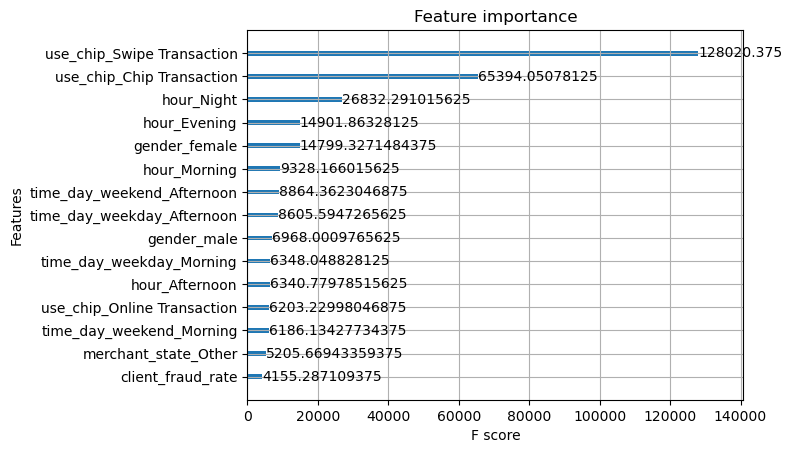

In [ ]:
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.show()

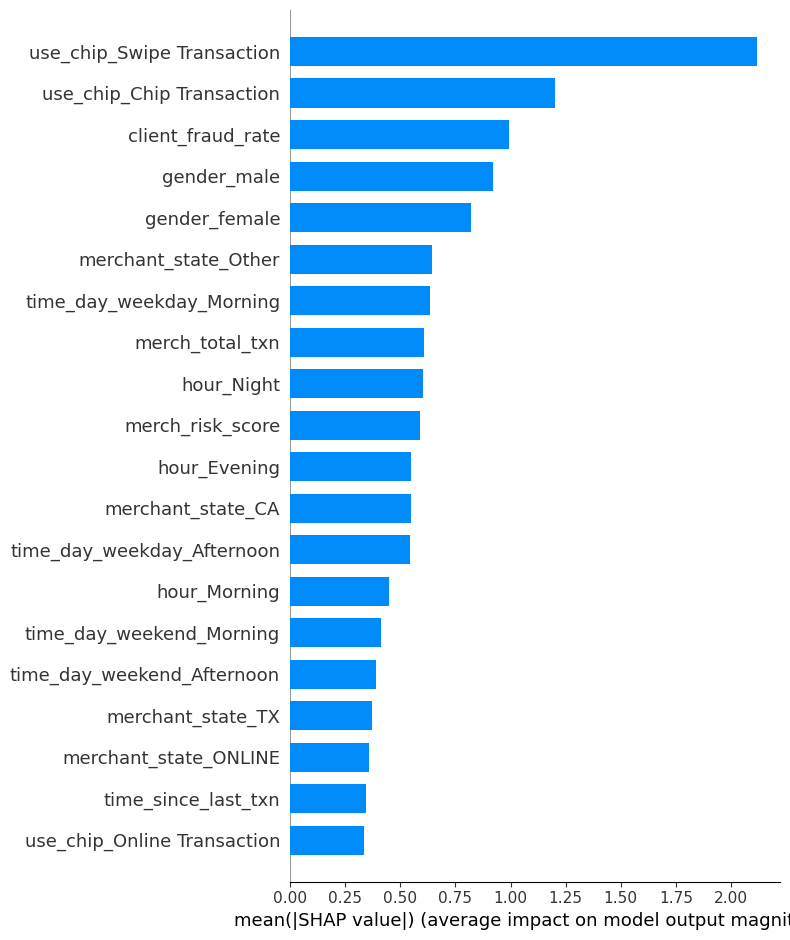

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

#### Hyperparameter tuning of XGBoost

This section loads the prepared dataset directly into code without the need to execute the steps above. 
Note: Tuning process never completed due to large dataset. Jump right to CatBoost considering superior base performance compared to XGB

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

prepared = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/prepared_data.csv')
prepared.info()

X = prepared.drop(['Target'], axis=1)
y = prepared['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_train_full, y_train_tune, y_train_full = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for tuning
param_grid = {
    'scale_pos_weight': [1, 2, 3, 5, 10, 20, 50, 100, 200],  # Adjust based on imbalance
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2]
}

# Define F2 score (beta=2 prioritizes recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# RandomizedSearchCV for hyperparameter tuning with resampling
def fit_model_with_resampling(X, y):
    # Apply resampling
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)
    
    # Fit the model
    random_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_grid,
        n_iter=100,
        scoring=f2_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)
    
    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_xgb_model = best_model.best_estimator_

# Resample the full training data and fit the model
X_train_full_resampled, y_train_full_resampled = imbalance_pipeline.fit_resample(X_train_full, y_train_full)

# Train the final model on the full resampled training data
best_xgb_model.fit(X_train_full_resampled, y_train_full_resampled)

# Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Plot feature importance and SHAP

In [ ]:
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=15)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

#### **Model 2: CatBoost**

Base model

In [9]:
#!pip install catboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train CatBoost with scale_pos_weight
model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    custom_metric=['AUC']  # For AUC scoring
)

# Train the model
model.fit(X_resampled, y_resampled, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.27      0.65      0.38      2666

    accuracy                           1.00   1782993
   macro avg       0.63      0.82      0.69   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC-AUC Score: 0.9760640077436216


In [ ]:
import joblib

# Save the model to a file using joblib as a backup due to problems in the tuning process
joblib.dump(model, 'catboost_model.joblib')

Adjust scale pos weight to heavily bias recall

In [ ]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train CatBoost with scale_pos_weight
model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    custom_metric=['AUC']  # For AUC scoring
)

# Train the model
model.fit(X_resampled, y_resampled, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 667.6639789986874
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.89   1780327
           1       0.01      0.96      0.01      2666

    accuracy                           0.79   1782993
   macro avg       0.50      0.88      0.45   1782993
weighted avg       1.00      0.79      0.88   1782993

ROC-AUC Score: 0.9631782676406769


In [14]:
import joblib

# Save the model to a file using joblib as a backup due to problems in the tuning process
joblib.dump(model, 'catboost_recall.joblib')

['catboost_recall.joblib']

#### CatBoost tuning

Note: Load data directly to execute the code here to reduce RAM usage for tuning process

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

prepared = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/prepared_data.csv')
prepared.info()

X = prepared.drop(['Target'], axis=1)
y = prepared['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 49 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   amount                       float64
 1   Target                       int64  
 2   current_age                  int64  
 3   retirement_age               int64  
 4   per_capita_income            float64
 5   yearly_income                float64
 6   total_debt                   float64
 7   credit_score                 int64  
 8   num_credit_cards             int64  
 9   use_chip_Chip Transaction    int64  
 10  use_chip_Online Transaction  int64  
 11  use_chip_Swipe Transaction   int64  
 12  merchant_state_CA            int64  
 13  merchant_state_FL            int64  
 14  merchant_state_IL            int64  
 15  merchant_state_MI            int64  
 16  merchant_state_NC            int64  
 17  merchant_state_NY            int64  
 18  merchant_state_OH            int64  
 19  

Tuning based on recall

In [16]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [3, 5, 7, 10],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'iterations': [20, 30, 40, 50],  # Number of iterations
    'l2_leaf_reg': [1, 3, 5, 10],  # L2 regularization term
}

# Define F2 score (beta=2 prioritizes recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=10,  # reduce iteration number for faster training
        scoring=f2_scorer,
        cv=3,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6762015	total: 1.92s	remaining: 36.4s
0:	learn: 0.5648780	total: 1.86s	remaining: 1m 31s
0:	learn: 0.6761753	total: 2.09s	remaining: 39.8s
0:	learn: 0.5653530	total: 1.92s	remaining: 1m 33s
0:	learn: 0.6685639	total: 2.71s	remaining: 2m 12s
0:	learn: 0.6758851	total: 2.05s	remaining: 39s
0:	learn: 0.6684773	total: 2.7s	remaining: 2m 12s
0:	learn: 0.6701453	total: 2.74s	remaining: 2m 14s
19:	learn: 0.4340139	total: 31.8s	remaining: 0us
19:	learn: 0.4321285	total: 31.6s	remaining: 0us
19:	learn: 0.4289586	total: 32s	remaining: 0us
0:	learn: 0.5647891	total: 1.61s	remaining: 1m 18s
0:	learn: 0.5099947	total: 1.07s	remaining: 52.6s
0:	learn: 0.5107186	total: 1.07s	remaining: 52.3s
49:	learn: 0.0743405	total: 1m 7s	remaining: 0us
49:	learn: 0.0672703	total: 1m 8s	remaining: 0us
0:	learn: 0.5105260	total: 1.76s	re

Change scoring metric to F1

In [ ]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [3, 5, 7, 10],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    #'iterations': [50, 75, 100],  # Number of iterations
    'l2_leaf_reg': [1, 3, 5, 10],  # L2 regularization term
}

# Define F1 score (beta=1 balances precision and recall)
f1_scorer = make_scorer(fbeta_score, beta=1)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=10,  # reduce iteration number for faster training
        scoring=f1_scorer,
        cv=5,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Compute precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold and F1 score
print("Best Threshold:", best_threshold)

# Apply best threshold for classification
y_pred_adj = (y_pred_proba >= best_threshold).astype(int)

# Print updated classification report and AUC score
print("Updated Classification Report:")
print(classification_report(y_test, y_pred_adj))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6759242	total: 1.33s	remaining: 1m 38s
0:	learn: 0.6758967	total: 1.51s	remaining: 1m 51s
0:	learn: 0.6755498	total: 2.27s	remaining: 2m 48s
0:	learn: 0.6758615	total: 2.17s	remaining: 2m 40s
0:	learn: 0.6759582	total: 2.33s	remaining: 2m 52s
0:	learn: 0.4913661	total: 3.11s	remaining: 5m 7s
0:	learn: 0.5067133	total: 3.08s	remaining: 5m 5s
0:	learn: 0.4945898	total: 3.04s	remaining: 5m
74:	learn: 0.1845878	total: 2m 24s	remaining: 0us
74:	learn: 0.1848280	total: 2m 24s	remaining: 0us
74:	learn: 0.1827049	total: 2m 23s	remaining: 0us
74:	learn: 0.1721270	total: 2m 24s	remaining: 0us
74:	learn: 0.1777731	total: 2m 25s	remaining: 0us
0:	learn: 0.5080555	total: 3.02s	remaining: 4m 59s
0:	learn: 0.4947758	total: 3.3s	remaining: 5m 26s
0:	learn: 0.3798318	total: 3.33s	remaining: 5m 30s
0:	learn: 0.3837052	total: 

In [18]:
print("Original Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Original Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.17      0.66      0.26      2666

    accuracy                           0.99   1782993
   macro avg       0.58      0.83      0.63   1782993
weighted avg       1.00      0.99      1.00   1782993

ROC-AUC Score: 0.9737118677184469


Change F1 scoring metric to favour precision

In [5]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [3, 5, 7, 10],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'iterations': [200],  # Number of iterations
    'l2_leaf_reg': [1, 3, 5, 10],  # L2 regularization term
}

# Define scoring metric (0.5 for precision)
scorer = make_scorer(fbeta_score, beta=0.5)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=10,  # reduce iteration number for faster training
        scoring=scorer,
        cv=5,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.5373864	total: 2.48s	remaining: 8m 14s
0:	learn: 0.5171177	total: 2.54s	remaining: 8m 26s
0:	learn: 0.5178629	total: 2.45s	remaining: 8m 6s
0:	learn: 0.6717584	total: 3.08s	remaining: 10m 13s
0:	learn: 0.6717815	total: 3.05s	remaining: 10m 7s
0:	learn: 0.6718069	total: 3.22s	remaining: 10m 40s
0:	learn: 0.6717426	total: 3.19s	remaining: 10m 34s
0:	learn: 0.6713486	total: 3.2s	remaining: 10m 36s
100:	learn: 0.0353695	total: 2m 57s	remaining: 2m 53s
100:	learn: 0.0285989	total: 2m 58s	remaining: 2m 54s
100:	learn: 0.0342808	total: 3m	remaining: 2m 56s
100:	learn: 0.0993947	total: 4m 9s	remaining: 4m 4s
100:	learn: 0.1008530	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.0921122	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.1007054	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.0996648	total: 4m 11s	remaining: 4m 6s

Realised that the performance models are all performing poorly when the training size was reduced, and iteration count lower than 1000. Try changing parameters of default parameters while keeping iteration at 1000 by default

In [8]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
#X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
#    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
#)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [6, 7, 8, 9],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5, 7],  # Minimum data in leaf
    'colsample_bylevel': [0.7, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.1, 0.2],  # Learning rate
    'l2_leaf_reg': [3, 5, 7, 9],  # L2 regularization term
}

# Define scoring metric (0.5 for precision)
scorer = make_scorer(fbeta_score, beta=0.5)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    #X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=5,  # reduce iteration number for faster training
        scoring=scorer,
        cv=3,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
#best_model = fit_model_with_resampling(X_train_tune, y_train_tune)
best_model = fit_model_with_resampling(X_resampled, y_resampled)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
#best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0:	learn: 0.4547056	total: 3.16s	remaining: 52m 36s
0:	learn: 0.4399395	total: 4.25s	remaining: 1h 10m 43s
0:	learn: 0.4578161	total: 5.95s	remaining: 1h 39m 8s
0:	learn: 0.4558979	total: 6.06s	remaining: 1h 40m 50s
0:	learn: 0.4379416	total: 6.46s	remaining: 1h 47m 30s
0:	learn: 0.4573387	total: 6.16s	remaining: 1h 42m 34s
0:	learn: 0.4540432	total: 6.41s	remaining: 1h 46m 43s
0:	learn: 0.4409340	total: 6.9s	remaining: 1h 54m 57s
100:	learn: 0.0395009	total: 7m 26s	remaining: 1h 6m 12s
100:	learn: 0.0335858	total: 7m 25s	remaining: 1h 6m 1s
100:	learn: 0.0383223	total: 7m 25s	remaining: 1h 6m 5s
100:	learn: 0.0368813	total: 7m 26s	remaining: 1h 6m 16s
100:	learn: 0.0337741	total: 7m 27s	remaining: 1h 6m 27s
100:	learn: 0.0333243	total: 7m 32s	remaining: 1h 7m 6s
100:	learn: 0.0331192	total: 7m 33s	remaining: 1h 7m 18s
1

In [9]:
# Compute precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold and F1 score
print("Best Threshold:", best_threshold)

# Apply best threshold for classification
y_pred_adj = (y_pred_proba >= best_threshold).astype(int)

# Print updated classification report and AUC score
print("Updated Classification Report:")
print(classification_report(y_test, y_pred_adj))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Best Threshold: 0.8901955049769718
Updated Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.70      0.47      0.56      2666

    accuracy                           1.00   1782993
   macro avg       0.85      0.74      0.78   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC-AUC Score: 0.9786364188418263


In [10]:
import joblib

# Save the model to a file using joblib as a backup due to problems in the tuning process
joblib.dump(best_catboost_model, 'catboost_balanced.joblib')

['catboost_balanced.joblib']

Change scoring to prioritise solely on precision

In [2]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
#X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
#    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
#)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [6, 7, 8, 9],  # Max depth for CatBoost
    'min_data_in_leaf': [3, 5, 7],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.1, 0.15, 0.2],  # Learning rate
    'l2_leaf_reg': [3, 5, 7, 9],  # L2 regularization term
}

# Define scoring metric based on precision score with emphasis on fraud class
scorer = make_scorer(precision_score, greater_is_better=True, pos_label=1)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    #X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=5,  # reduce iteration number for faster training
        scoring=scorer,
        cv=3,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_resampled, y_resampled)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
#best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0:	learn: 0.5454727	total: 5.42s	remaining: 1h 30m 16s
0:	learn: 0.4767449	total: 5.68s	remaining: 1h 34m 37s
0:	learn: 0.5426538	total: 5.36s	remaining: 1h 29m 11s
0:	learn: 0.5291663	total: 6.11s	remaining: 1h 41m 46s
0:	learn: 0.4567613	total: 5.9s	remaining: 1h 38m 15s
0:	learn: 0.4777433	total: 6.25s	remaining: 1h 44m 5s
0:	learn: 0.5288709	total: 6.24s	remaining: 1h 43m 54s
0:	learn: 0.5246031	total: 6.44s	remaining: 1h 47m 11s
100:	learn: 0.0450888	total: 8m 7s	remaining: 1h 12m 20s
100:	learn: 0.0400326	total: 8m 10s	remaining: 1h 12m 49s
100:	learn: 0.0283803	total: 8m 39s	remaining: 1h 17m 1s
100:	learn: 0.0342096	total: 8m 40s	remaining: 1h 17m 17s
100:	learn: 0.0367663	total: 8m 42s	remaining: 1h 17m 34s
100:	learn: 0.0343121	total: 8m 42s	remaining: 1h 17m 34s
100:	learn: 0.0377637	total: 8m 46s	remaining: 1

In [3]:
# Compute precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold and F1 score
print("Best Threshold:", best_threshold)

# Apply best threshold for classification
y_pred_adj = (y_pred_proba >= best_threshold).astype(int)

# Print updated classification report and AUC score
print("Updated Classification Report:")
print(classification_report(y_test, y_pred_adj))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Best Threshold: 0.8528827718140968
Updated Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.68      0.49      0.57      2666

    accuracy                           1.00   1782993
   macro avg       0.84      0.74      0.79   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC-AUC Score: 0.9803809247023908


In [5]:
import joblib

# Save the model to a file using joblib as a backup due to problems in the tuning process
joblib.dump(best_catboost_model, 'catboost_precision.joblib')

['catboost_precision.joblib']

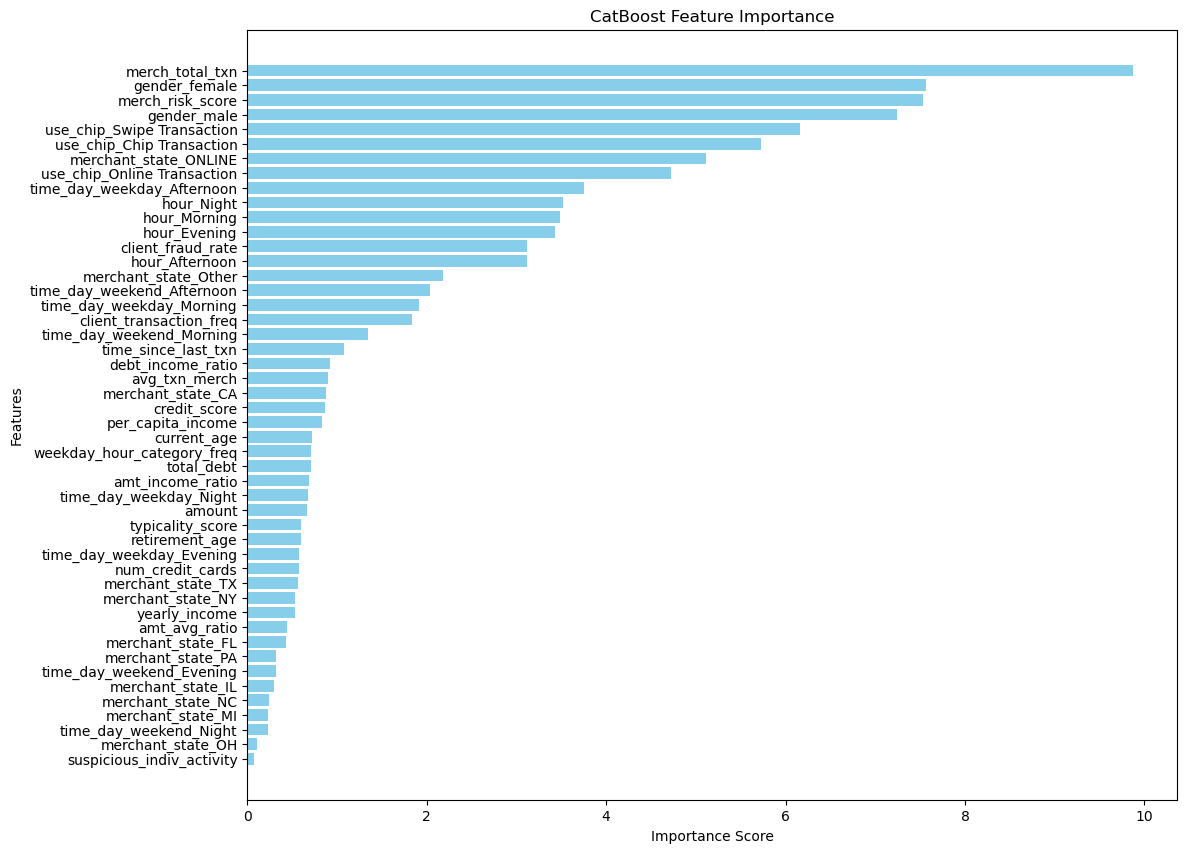

In [8]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_catboost_model.get_feature_importance()
feature_names = X_train.columns 

# Create a DataFrame for plotting
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

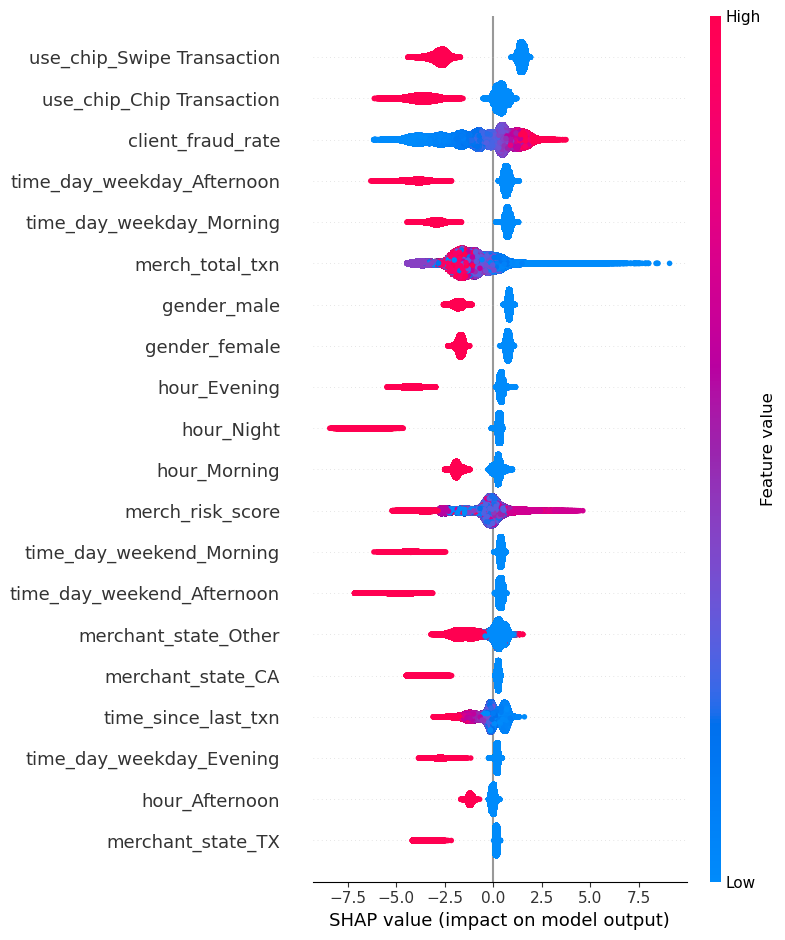

In [10]:
import shap

# Get SHAP values
explainer = shap.TreeExplainer(best_catboost_model)
shap_values = explainer.shap_values(X_train)

# Plot summary plot
shap.summary_plot(shap_values, X_train)